# **Sentiment Analysis with Pinecone and Hugging Face**
## **Overview**
This project leverages Pinecone's vector database and Hugging Face's NLP models to perform sentiment analysis on text data. By combining powerful embeddings with large language models (LLMs), we can analyze text more effectively, understanding the underlying sentiment --- whether it's positive, negative, or neutral.

### **What is Hugging Face?**
Hugging Face is an open-source AI company that provides state-of-the-art natural language processing (NLP) models. Their transformers library offers pre-trained models for tasks like sentiment analysis, translation, text generation, and more. In this project, we utilize one of these pre-trained models to convert text data into embeddings --- numerical representations capturing the context and meaning of the text.

### **What is Pinecone?**
Pinecone is a vector database designed for fast and scalable similarity searches. It efficiently stores high-dimensional embeddings and enables rapid querying, making it ideal for tasks like semantic search, recommendation systems, and --- in our case --- sentiment analysis.

### **Why Embeddings and LLMs?**
Embeddings are dense numerical representations of data (e.g., text) in a lower-dimensional space. They capture semantic meaning, allowing the model to understand text beyond simple word matching. By leveraging embeddings from Hugging Face models and storing them in Pinecone, we can:

**Analyze sentiment** --- Understand the emotional tone of a given text.

**Compare text similarity** --- Detect patterns and group similar texts.

**Scale efficiently** --- Pinecone handles large datasets without performance degradation.

In [1]:
! pip install sentence_transformers pinecone-client datasets seaborn matplotlib

# **Load and Prepare Dataset**

In [2]:
from datasets import load_dataset

In [3]:
df = load_dataset('ashraq/hotel-reviews',split='train').to_pandas()

README.md:   0%|          | 0.00/548 [00:00<?, ?B/s]

(…)-00000-of-00001-d30d4a38ef4cc157.parquet:   0%|          | 0.00/6.10M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/93757 [00:00<?, ? examples/s]

In [4]:
df.head()

review_date                     hotel_name  \
0    8/3/2017  Park Plaza County Hall London   
1    8/3/2017  Park Plaza County Hall London   
2    8/3/2017  Park Plaza County Hall London   
3    8/2/2017  Park Plaza County Hall London   
4    8/2/2017  Park Plaza County Hall London   

                                              review  
0   Extra bed was the worst breakfast queue was r...  
1                         Just the location and view  
2   Around the corner from the London eye and use...  
3                   I wish you had wheat free snacks  
4   You re always my hotel of choice You re staff...

In [5]:
# we keep only the first 800 characters of each review
df["review"] = df['review'].str[:800]
df.head()

review_date                     hotel_name  \
0    8/3/2017  Park Plaza County Hall London   
1    8/3/2017  Park Plaza County Hall London   
2    8/3/2017  Park Plaza County Hall London   
3    8/2/2017  Park Plaza County Hall London   
4    8/2/2017  Park Plaza County Hall London   

                                              review  
0   Extra bed was the worst breakfast queue was r...  
1                         Just the location and view  
2   Around the corner from the London eye and use...  
3                   I wish you had wheat free snacks  
4   You re always my hotel of choice You re staff...

# **Initializing the sentiment model**

In [6]:
import torch

In [7]:
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
from transformers import pipeline,AutoTokenizer,AutoModelForSequenceClassification

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [10]:
# loading the sentiment analysis model 
model_id = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_id,
                                                          num_labels=3)
# loading the tokenizer from Huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)
# loading both the model and the tokenizer into the sentiment analysis pipeline
nlp = pipeline("sentiment-analysis",
               model=model,
              tokenizer=tokenizer,
              device = device)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [11]:
labels = {
    'LABEL_0':'negative',
    'LABEL_1':'neutral',
    'LABEL_2':'positive'
}

In [12]:
test = df['review'][241]
test

' Room was small for a superior room and poorly lit especially as it was an inside room and overlooked the inside wall of the hotel No view therefore needed better lighting within Restaurant tables were not well laid and had to go searching for cutlery at breakfast '

In [13]:
# applying the nlp model
nlp(test)

[{'label': 'LABEL_0', 'score': 0.7736574411392212}]

# **initalizing the retrievel model** 

In [14]:
from sentence_transformers import SentenceTransformer

In [15]:
# loading the model from hugging face
retriever = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2',
                              device=device)
retriever

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# **Initializing the Pinecone Index**

In [16]:
!pip uninstall -y pinecone-client

Found existing installation: pinecone-client 6.0.0
Uninstalling pinecone-client-6.0.0:
  Successfully uninstalled pinecone-client-6.0.0


In [17]:
! pip install pinecone

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 17.1 MB/s eta 0:00:00


In [18]:
key = "pcsk_5VXdpR_UaDYWRTemDNVZh8SUz9wQSTuT2rGSZnNwStFmm6XRtMUurb1wAuyUxMDxhzpzki"

In [19]:
import pinecone
from pinecone import Pinecone

# **sentiment-analysis-vector** 

In [20]:
from pinecone import Pinecone, ServerlessSpec

from pinecone import Pinecone

pc = Pinecone(api_key=key)
index = pc.Index("sentiment-analysis-vector")


In [21]:
def get_sentiment(reviews):
    sentiments = nlp(reviews)
    i = [labels[x["label"]] for x in sentiments]
    s = [x["score"] for x in sentiments]
    return i , s 

In [22]:
get_sentiment(df['review'][:10].tolist())

(['negative',
  'neutral',
  'positive',
  'neutral',
  'positive',
  'neutral',
  'positive',
  'negative',
  'positive',
  'negative'],
 [0.9065250754356384,
  0.7716172933578491,
  0.8975034952163696,
  0.6135808229446411,
  0.9900740385055542,
  0.6364567875862122,
  0.9828112125396729,
  0.9010939598083496,
  0.9400402307510376,
  0.9517661333084106])

In [23]:
df.dtypes

review_date    object
hotel_name     object
review         object
dtype: object

In [24]:
import dateutil.parser

In [25]:
def get_timestamp(dates):
    timestamp = [dateutil.parser.parse(d).timestamp() for d in dates]
    return timestamp

In [26]:
get_timestamp([df["review_date"][0]])[0]

1501718400.0

In [27]:
from tqdm.auto import tqdm

batch_size = 64

# due to the processing time i will work with 100 batch u can use the len(df) to apply the process to the entire data 

for i in tqdm(range(0, 64*100, batch_size), desc="Processing batches"):
    try:
        # Define batch range
        i_end = min(i + batch_size, 64*100)
        batch = df.iloc[i:i_end]

        # Encode reviews into embeddings
        emb = retriever.encode(batch["review"].tolist()).tolist()

        # Get timestamps and sentiment analysis
        timestamp = get_timestamp(batch['review_date'].tolist())
        label, score = get_sentiment(batch['review'].tolist())
        
        # Add new data to batch
        batch['label'], batch['score'] = label, score

        # Prepare metadata and IDs
        meta = batch.to_dict(orient="records")
        ids = [str(idx) for idx in range(i, i_end)]

        # Prepare data for upsert and push to index
        to_upsert = list(zip(ids, emb, meta))
        _ = index.upsert(vectors=to_upsert)

    except Exception as e:
        print(f"❗ Error processing batch {i // batch_size + 1}: {e}")

# Display index stats after all batches
stats = index.describe_index_stats()
print("✅ Index stats:", stats)


Processing batches:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Index stats: {'dimension': 384,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'': {'vector_count': 6400}},
 'total_vector_count': 6400,
 'vector_type': 'dense'}


# **client satisfaction with the room sizes`RSS`**

In [28]:
query = "are customers satisfied with the room sizees of hotels in london ?"
xq = retriever.encode(query).tolist()

result = index.query(
    vector=xq, top_k=1000,
    include_metadata = True,
)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [30]:
import pandas as pd 

In [31]:
data = result['matches']
RSS_data = pd.DataFrame([
    {
        'id': r['id'],
        'similarity_score': r['score'],
        'hotel_name': r['metadata']['hotel_name'],
        'label': r['metadata']['label'],
        'review': r['metadata']['review'],
        'review_date': r['metadata']['review_date'],
        'sentiment_score': r['metadata']['score']
    }
    for r in data
])

In [32]:
RSS_data.head()

id  similarity_score                     hotel_name     label  \
0  1950          0.813276  Park Plaza County Hall London  positive   
1  4820          0.759289  Grand Royale London Hyde Park  positive   
2  5448          0.755385  Grand Royale London Hyde Park  negative   
3  6169          0.754636  Grand Royale London Hyde Park  positive   
4  5345          0.754249  Grand Royale London Hyde Park   neutral   

                                              review review_date  \
0   Was a good size room considering it s a Londo...   6/12/2017   
1   The hotel is rich in history and in great loc...   9/29/2016   
2   The rooms are extremely small as I had booked...    4/2/2016   
3   Room could be bigger but I can t complain giv...   9/11/2015   
4   Rooms are not spacious but typical for London...    5/7/2016   

   sentiment_score  
0         0.897906  
1         0.949293  
2         0.556439  
3         0.755736  
4         0.584050

In [33]:
import seaborn as sns 

<Axes: xlabel='label', ylabel='count'>

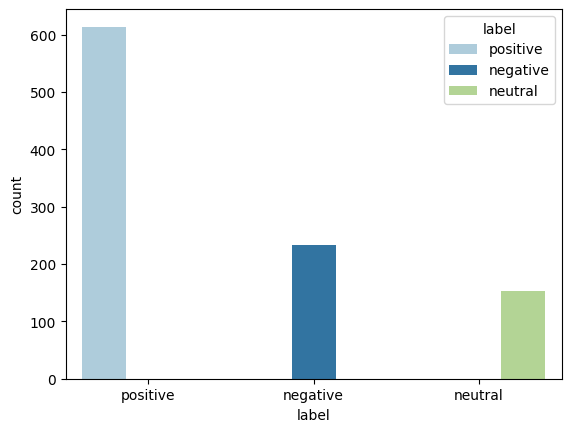

In [34]:
sns.countplot(RSS_data,x='label',hue='label',palette='Paired')

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0, 0.5, '')

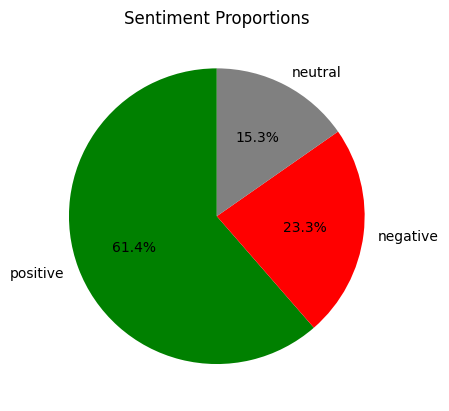

In [36]:
sentiment_count = RSS_data['label'].value_counts()
sentiment_count.plot(kind='pie',autopct='%1.1F%%',startangle=90,colors=['green','red','gray'])
plt.title('Sentiment Proportions')
plt.ylabel('')

In [37]:
sentiment_count.index

Index(['positive', 'negative', 'neutral'], dtype='object', name='label')

In [38]:
hotel_names = RSS_data['hotel_name'].unique()
hotel_names

array(['Park Plaza County Hall London', 'Grand Royale London Hyde Park'],
      dtype=object)

In [39]:
pip install nltk wordcloud

Note: you may need to restart the kernel to use updated packages.


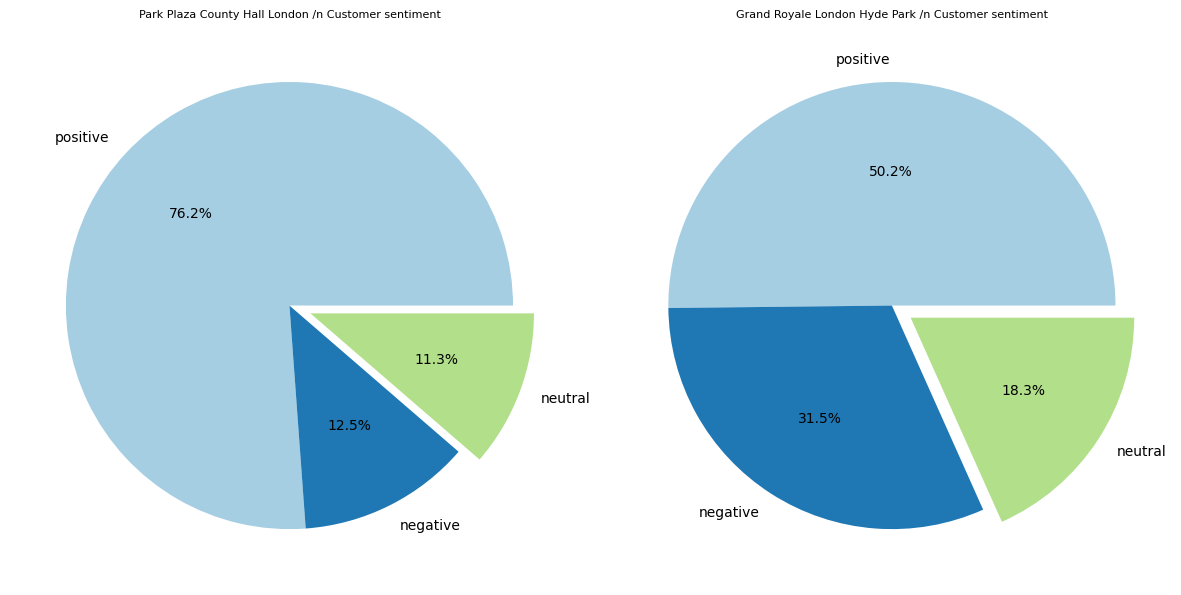

In [40]:
explode = [0,0,0.1]
palette_color = sns.color_palette('Paired') 
fig , ax = plt.subplots(1,2,figsize=(12,6))
for i,hotel in enumerate (hotel_names):
    sentiment_count = RSS_data[RSS_data['hotel_name']==hotel]['label'].value_counts()
    ax[i].pie(sentiment_count ,labels = sentiment_count.index , colors = palette_color,explode=explode,autopct = '%1.1F%%')
    ax[i].set_title(f'{hotel} /n Customer sentiment',size=8)
plt.tight_layout()    
    

In [41]:
import nltk
import string
from scipy.sparse import csr_matrix
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [42]:
from nltk.corpus import stopwords
nltk.download('stopwords')

In [44]:
def clean_text(text):
    stop_words = set(stopwords.words('english'))
    text = text.translate(str.maketrans('','',string.punctuation)).lower()
    words = text.split()
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

In [45]:
RSS_data['review']=RSS_data['review'].apply(clean_text)

In [46]:
pos_RSS_reviews = " ".join(RSS_data[RSS_data['label']=='positive']['review'])
neg_RSS_reviews = " ".join(RSS_data[RSS_data['label']=='negative']['review'])

In [47]:
pos_word_cloud = WordCloud(
    stopwords =set(stopwords.words('english')),
    width = 800 , height=400, background_color = 'white',colormap='Blues'
).generate(pos_RSS_reviews)

neg_word_cloud = WordCloud(
    stopwords =set(stopwords.words('english')),
    width = 800 , height=400, background_color = 'white',colormap='inferno'
).generate(neg_RSS_reviews)

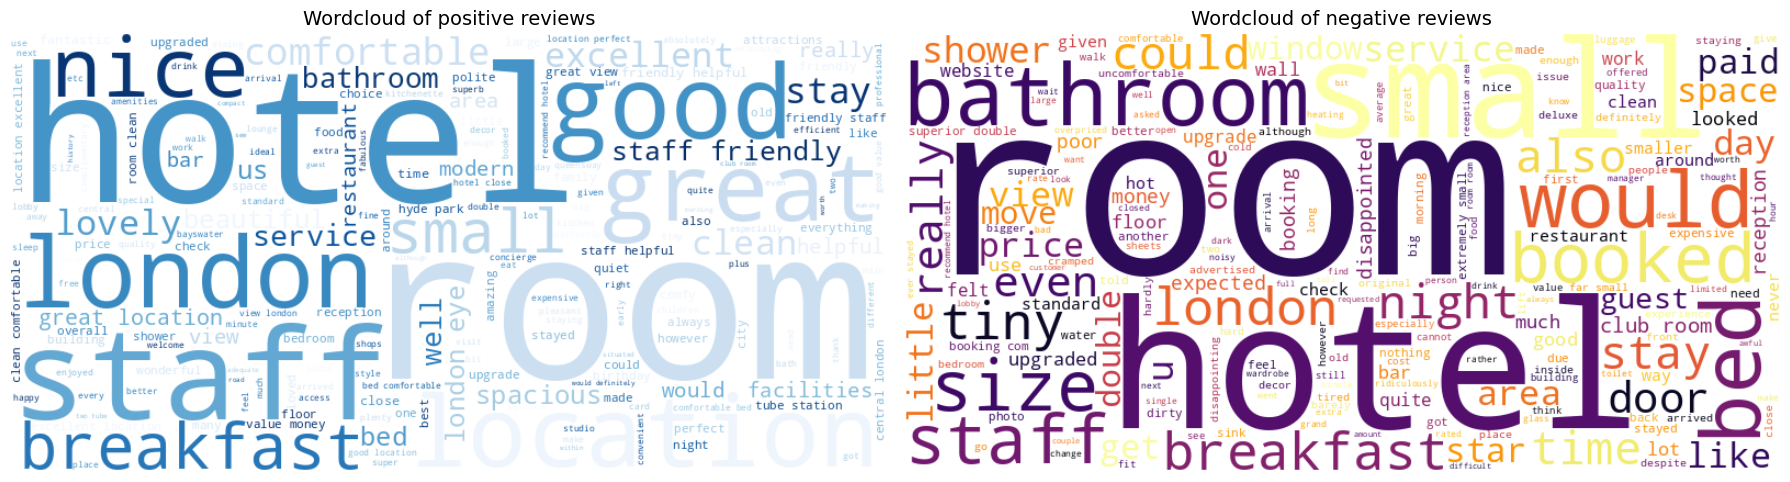

In [49]:
plt.figure(figsize=(18,9))

plt.subplot(1,2,1)
plt.imshow(pos_word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of positive reviews',size=14)
plt.subplot(1,2,2)
plt.imshow(neg_word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of negative reviews',size=14)


plt.tight_layout()
plt.show()

In [87]:
from IPython.display import Markdown

In [92]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def Query_and_report(query):
    display(Markdown(f"# **{query}**"))
    # Process query and fetch data
    xq = retriever.encode(query).tolist()

    result = index.query(vector=xq, top_k=1000, include_metadata=True)
    data = result['matches']
    
    # Convert to DataFrame
    data = pd.DataFrame([
        {
            'id': r['id'],
            'similarity_score': r['score'],
            'hotel_name': r['metadata']['hotel_name'],
            'label': r['metadata']['label'],
            'review': r['metadata']['review'],
            'review_date': r['metadata']['review_date'],
            'sentiment_score': r['metadata']['score']
        }
        for r in data
    ])

    # Unique hotel names
    hotel_names = data['hotel_name'].unique()

    # Set up the figure with dynamic number of subplots (3 rows now)
    fig, ax = plt.subplots(3, len(hotel_names), figsize=(6 * len(hotel_names), 15))

    # Ensure ax is iterable (even for one hotel)
    if len(hotel_names) == 1:
        ax = [[ax[i]] for i in range(3)]

    explode = [0, 0, 0.1]

    # Loop through each hotel to create pie charts and word clouds
    for i, hotel in enumerate(hotel_names):
        # --- Pie Chart ---
        sentiment_count = data[data['hotel_name'] == hotel]['label'].value_counts()

        ax[0][i].pie(
            sentiment_count,
            labels=sentiment_count.index,
            colors=sns.color_palette('Paired', len(sentiment_count)),
            explode=explode[:len(sentiment_count)],
            autopct='%1.1f%%'
        )
        ax[0][i].set_title(f'{hotel} Customer Sentiment', size=10)

        # --- Positive Word Cloud ---
        positive_reviews = " ".join(
            data[(data['hotel_name'] == hotel) & (data['label'] == 'positive')]['review'].astype(str)
        )
        if positive_reviews:
            positive_wc = WordCloud(
                width=400,
                height=300,
                background_color='white',
                colormap='Greens',
                max_words=100
            ).generate(positive_reviews)

            ax[1][i].imshow(positive_wc, interpolation='bilinear')
            ax[1][i].axis('off')
            ax[1][i].set_title(f"{hotel} Positive Reviews", size=10)
        else:
            ax[1][i].axis('off')
            ax[1][i].set_title(f"{hotel} No Positive Reviews", size=10)

        # --- Negative Word Cloud ---
        negative_reviews = " ".join(
            data[(data['hotel_name'] == hotel) & (data['label'] == 'negative')]['review'].astype(str)
        )
        if negative_reviews:
            negative_wc = WordCloud(
                width=400,
                height=300,
                background_color='white',
                colormap='Reds',
                max_words=100
            ).generate(negative_reviews)

            ax[2][i].imshow(negative_wc, interpolation='bilinear')
            ax[2][i].axis('off')
            ax[2][i].set_title(f"{hotel} Negative Reviews", size=10)
        else:
            ax[2][i].axis('off')
            ax[2][i].set_title(f"{hotel} No Negative Reviews", size=10)

    plt.tight_layout()
    plt.show()



# **are customers satisfied with the food quality**

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

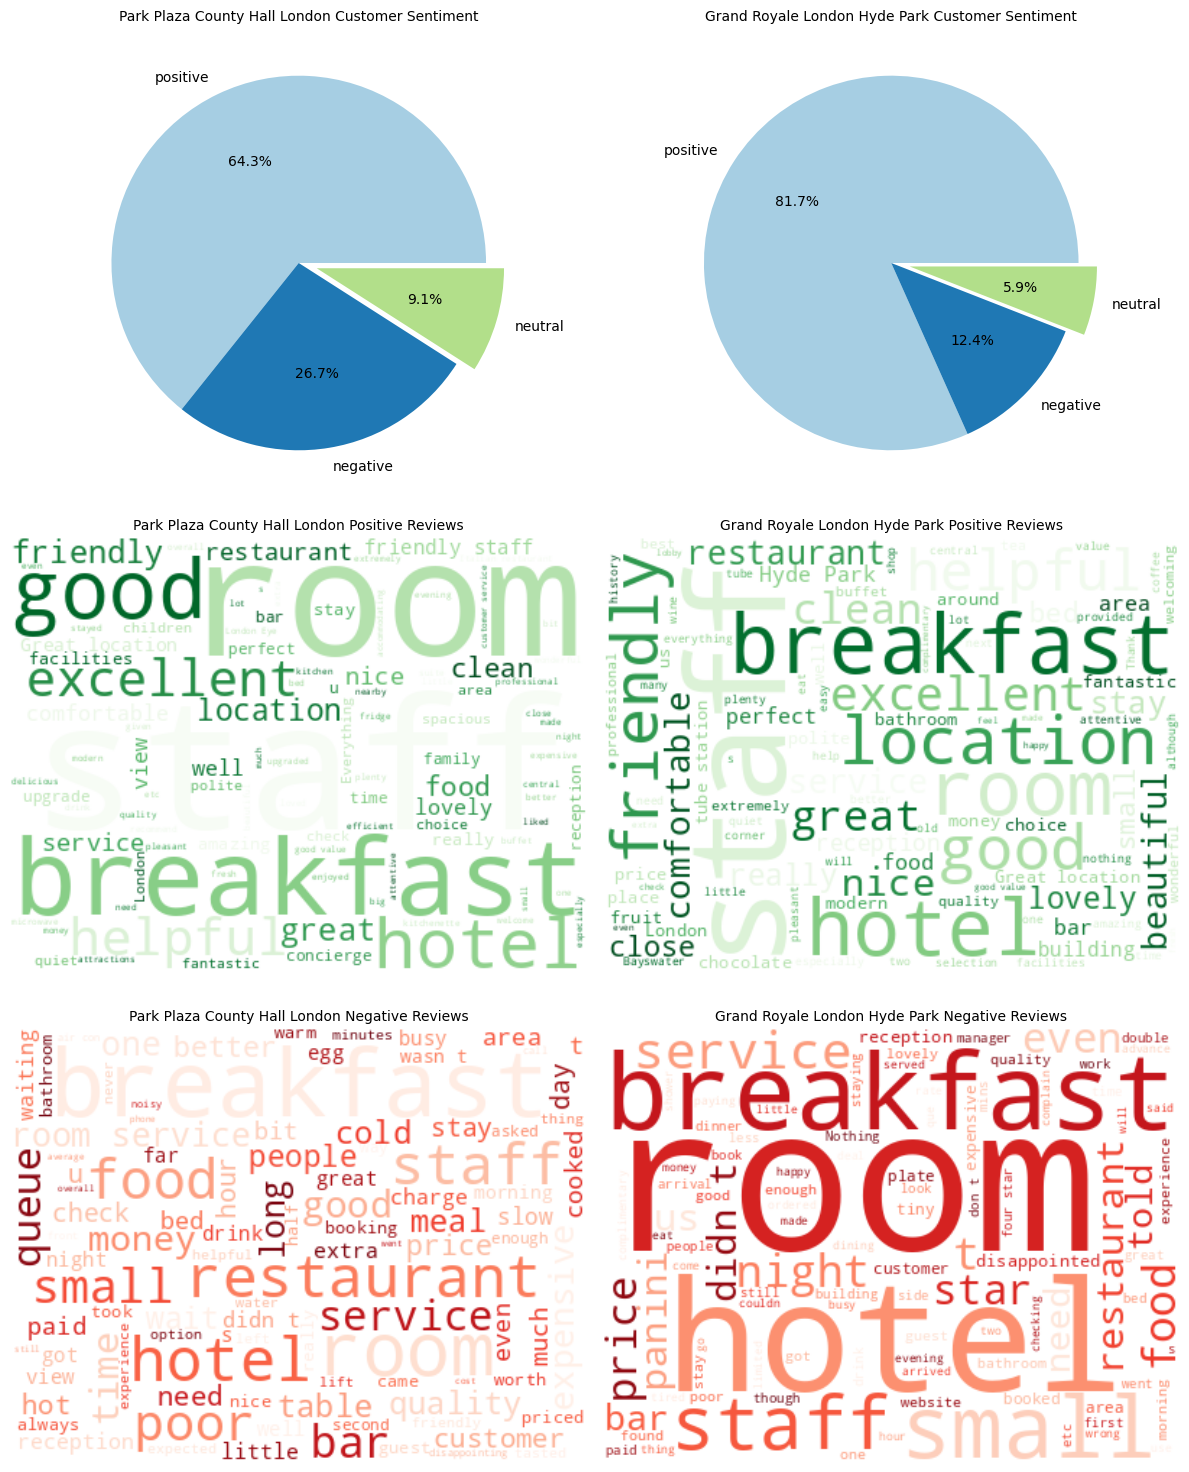

# **are customers satisfied with the stuff services**

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

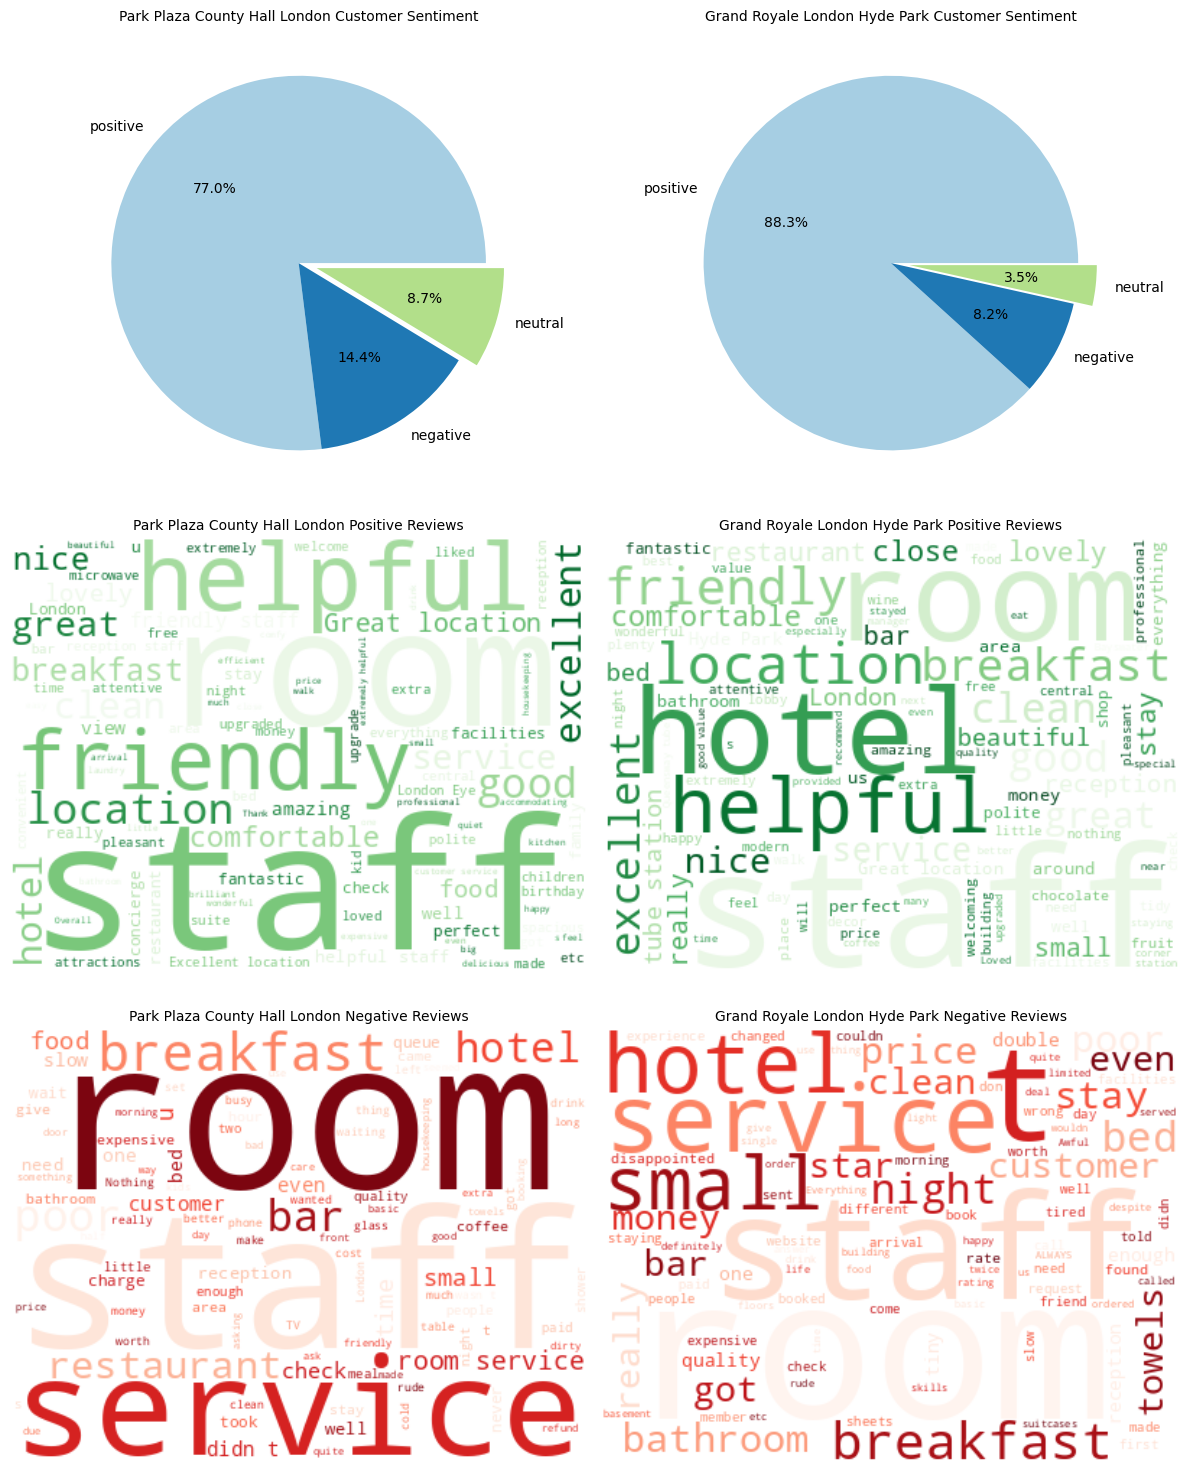

# **are customers satisfied with the room service**

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

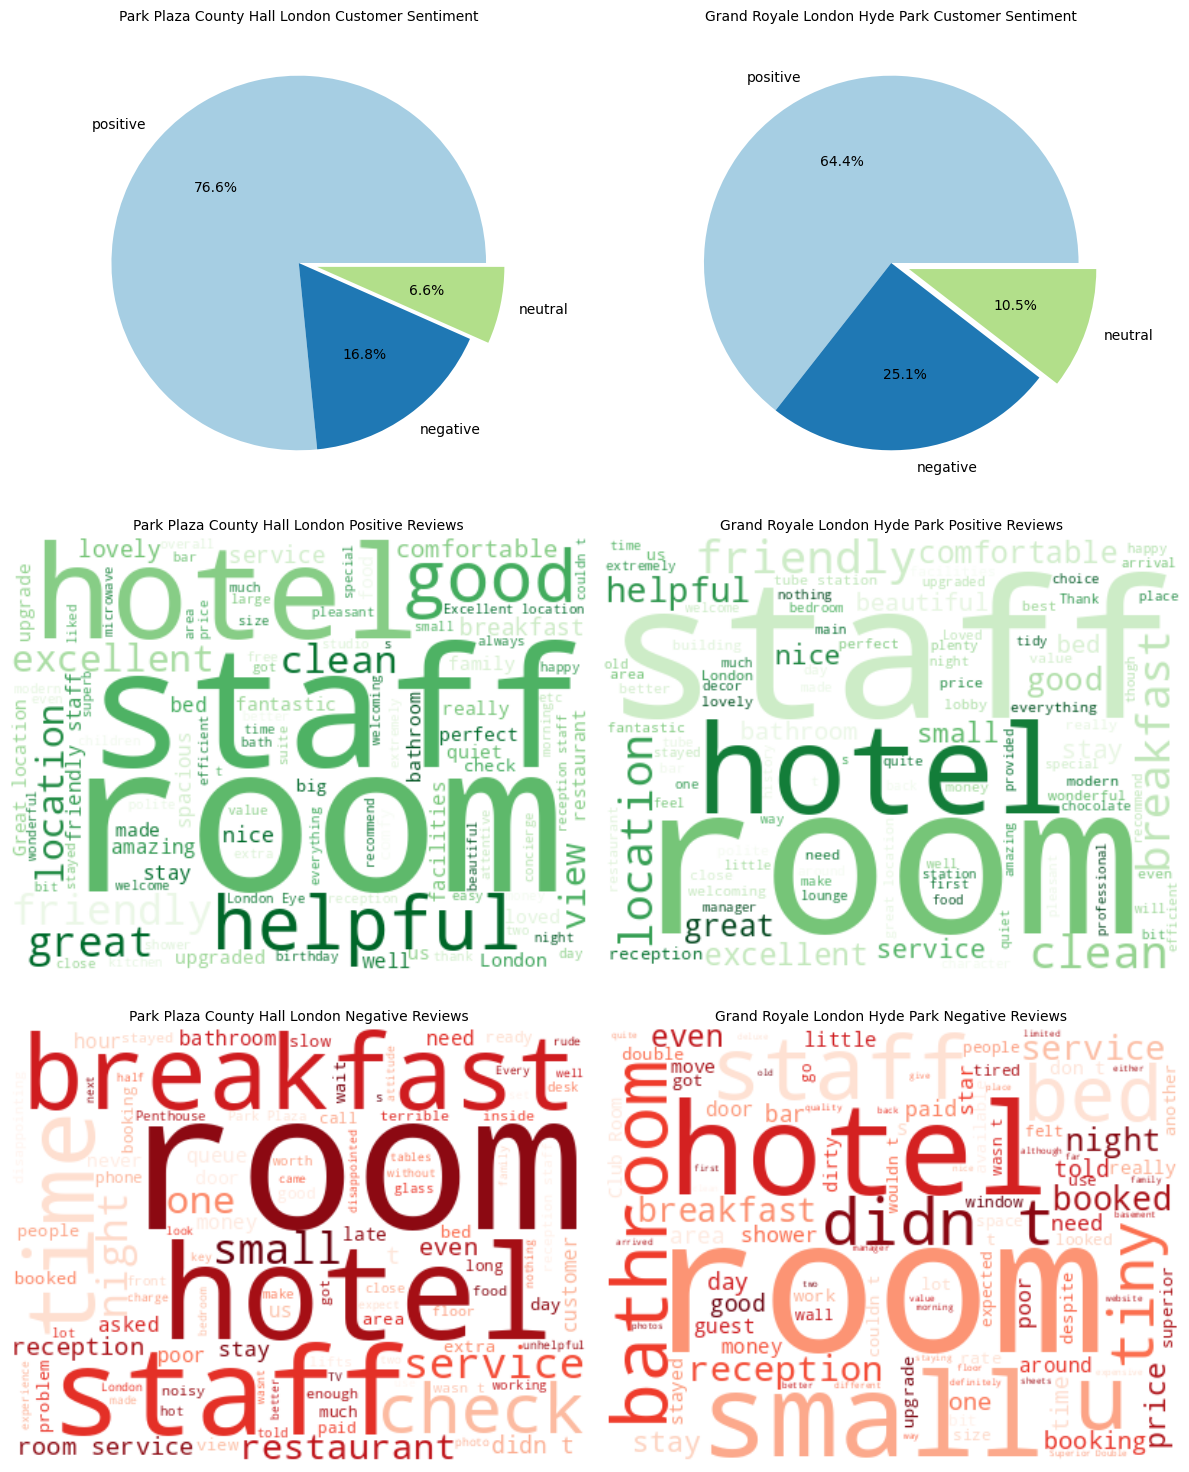

# **is the wifi good**

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

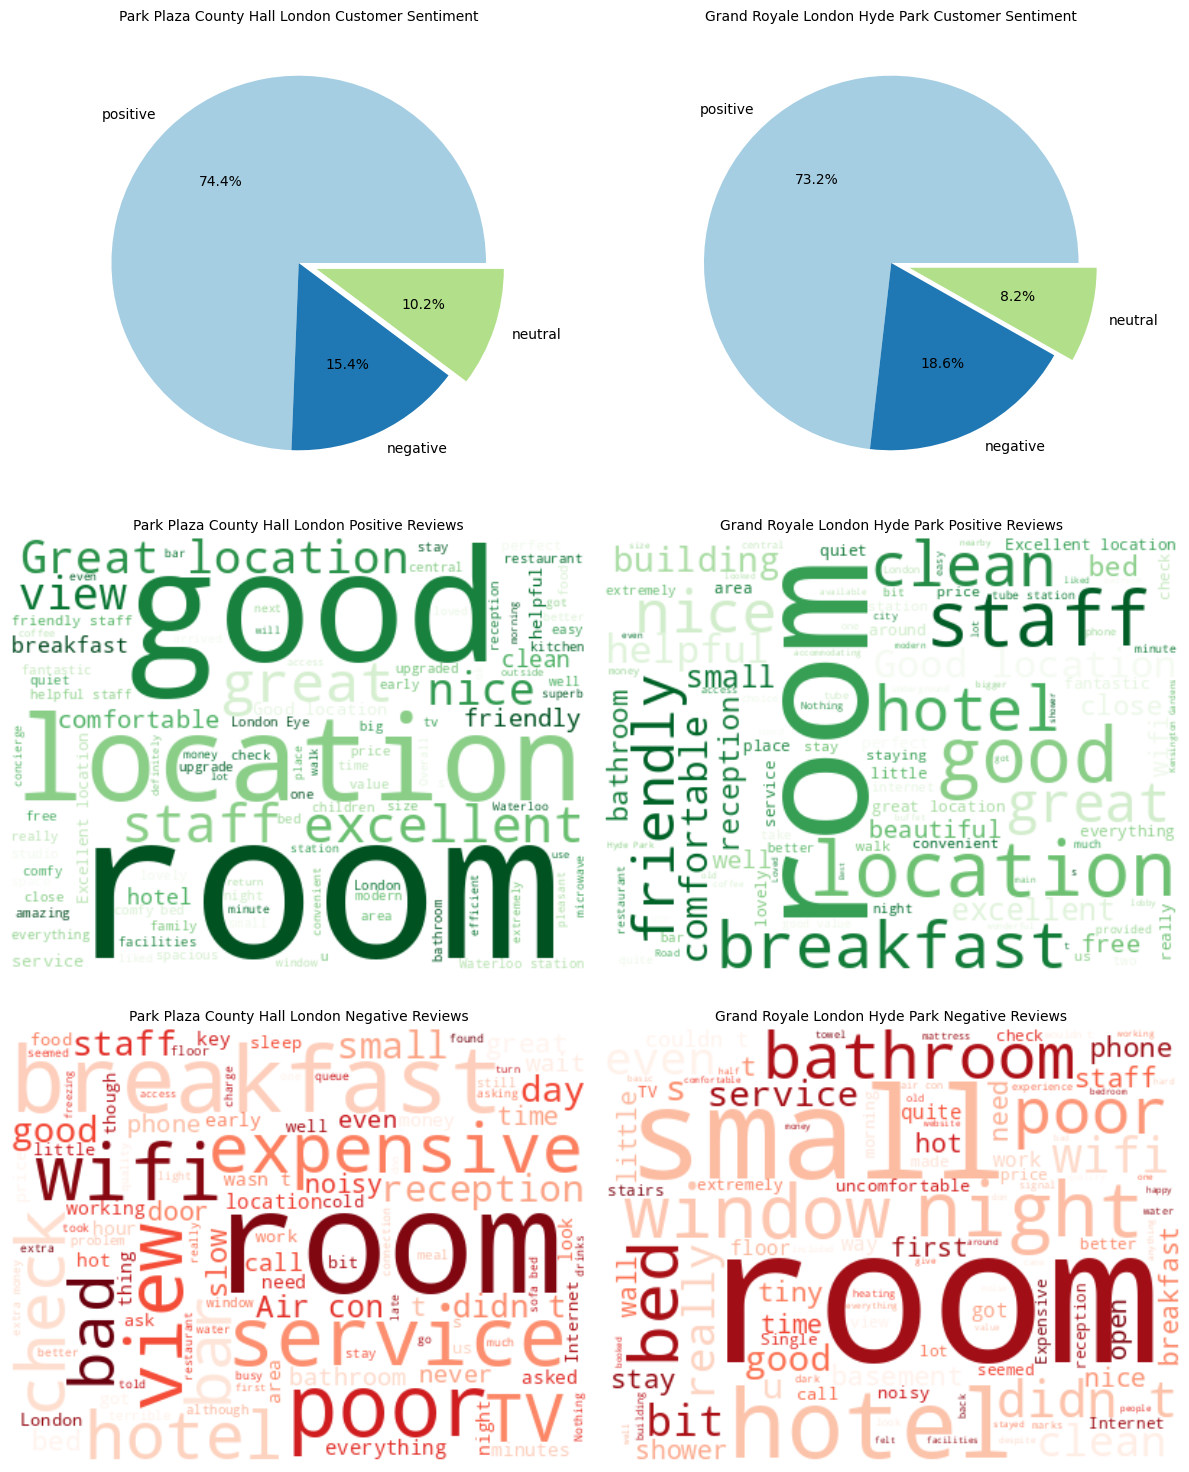

# **is there any problem with the reception**

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

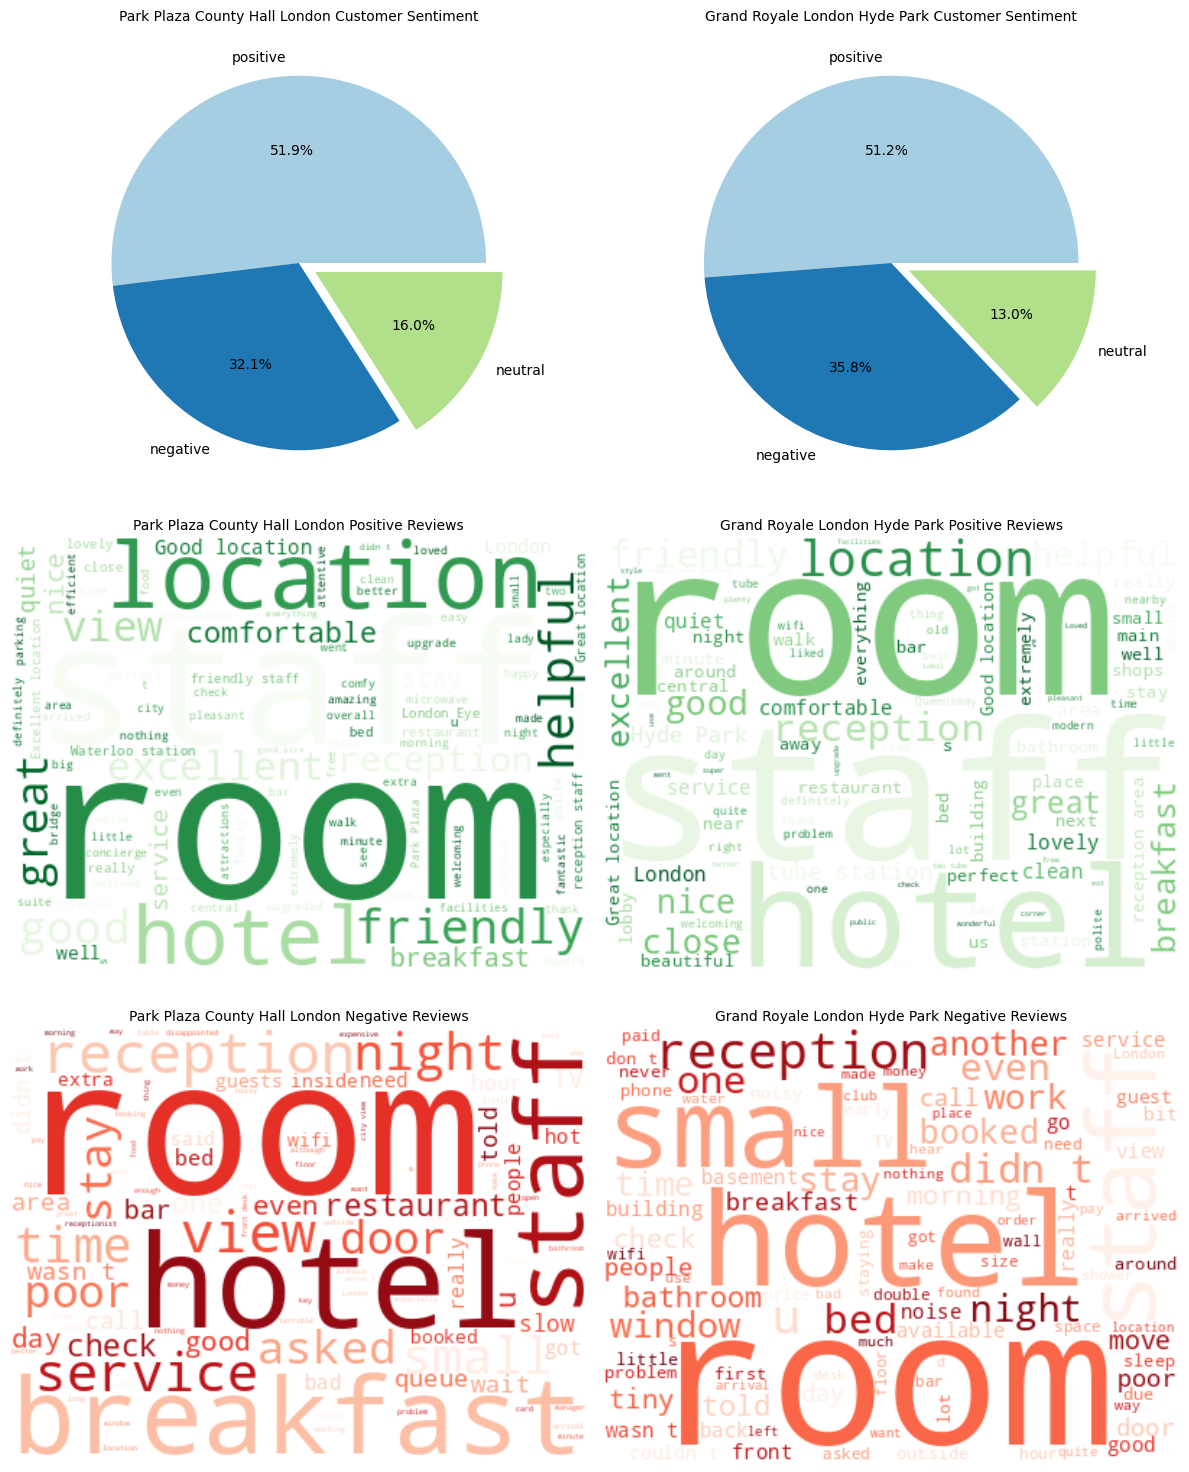

In [97]:
queries = ['are customers satisfied with the food quality','are customers satisfied with the stuff services','are customers satisfied with the room service','is the wifi good','is there any problem with the reception']

for q in queries:
    Query_and_report(q)